In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)


In [2]:
print(torch.__version__)
print(torchvision.__version__)

1.11.0
0.12.0


In [7]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels =1,out_channels = 6,kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels =6,out_channels = 12,kernel_size=5)

        self.fc1 = nn.Linear(in_features=12*4*4,out_features=12)
        self.fc2 = nn.Linear(in_features=12,out_features=60)
        self.out = nn.Linear(in_features=60,out_features=10)

    def forward(self,t):
        #t = t #第一层输入
        t = F.relu(self.conv1(t))
        t = F.max_pool2d(t, kernel_size =2,stride=2)

        t = F.relu(self.conv2(t))
        t = F.max_pool2d(t,kernel_size = 2,stride =2)

        t = t.reshape(-1,12*4*4)
        t = F.relu(self.fc1(t))

        t = F.relu(self.fc2(t))

        t = self.out(t)

        return t


In [3]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data/'
    ,train=True
    ,download=True
    ,transform = transforms.Compose([
        transforms.ToTensor()
    ])
)

In [4]:
len(train_set)

60000

In [6]:
len(train_set.targets)

60000

In [9]:
def get_num_correct(preds,labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [11]:
network = Network()

train_loader = torch.utils.data.DataLoader(train_set,batch_size=100)
optimizer = optim.Adam(network.parameters(),lr = 0.01)

total_loss = 0
total_correct = 0

for epoch in range(5):
    total_loss = 0
    total_correct = 0
    for batch in train_loader:
        images,labels = batch
        
        preds = network(images)
        loss = F.cross_entropy(preds,labels)
        #------------要将梯度归零 因为pytorch会累加梯度
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += get_num_correct(preds,labels)
    print("epoch:",epoch,"total_correct",total_correct," loss:",total_loss)

epoch: 0 total_correct 45373  loss: 387.82336789369583
epoch: 1 total_correct 50349  loss: 263.26504787802696
epoch: 2 total_correct 50871  loss: 246.37269008159637
epoch: 3 total_correct 51194  loss: 238.3699927330017
epoch: 4 total_correct 51370  loss: 231.80773247778416


## 获得在所有训练集中的预测

In [12]:
def get_all_preds(model,loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images,labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds,preds)
            ,dim=0
        )
    return all_preds

In [13]:
prediction_loader = torch.utils.data.DataLoader(train_set,batch_size=1000)
train_preds = get_all_preds(network,prediction_loader)

In [14]:
train_preds.shape

torch.Size([60000, 10])

In [15]:
print(train_preds.requires_grad)

True


In [17]:
train_preds.grad

e:\Anaconda\envs\pytorch\lib\site-packages\torch\_tensor.py:1104: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  C:\cb\pytorch_1000000000000\work\build\aten\src\ATen/core/TensorBody.h:475.)
  return self._grad


In [18]:
train_preds.grad_fn

In [19]:
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(train_set,batch_size = 10000)
    train_preds = get_all_preds(network,prediction_loader)

In [20]:
print(train_preds.requires_grad)

False


In [24]:
train_preds.grad

In [21]:
train_preds.grad_fn

In [25]:
preds_correct = get_num_correct(train_preds,train_set.targets)

print('total correct:',preds_correct)
print('accuracy:',preds_correct/len(train_set))

total correct: 51329
accuracy: 0.8554833333333334


## 建立混淆矩阵

In [26]:
train_set.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [27]:
train_preds.argmax(dim=1)

tensor([9, 0, 3,  ..., 3, 0, 5])

In [33]:
stacked = torch.stack(
    (
        train_set.targets
        ,train_preds.argmax(dim=1)
    )
    ,dim=1
)

In [34]:
stacked.shape

torch.Size([60000, 2])

In [35]:
stacked

tensor([[9, 9],
        [0, 0],
        [0, 3],
        ...,
        [3, 3],
        [0, 0],
        [5, 5]])

In [36]:
stacked[0].tolist()

[9, 9]

In [31]:
cmt = torch.zeros(10,10,dtype=torch.int32)
cmt

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)

In [37]:
j,k = stacked[0].tolist()

In [38]:
j

9

In [39]:
k

9

In [40]:
for p in stacked:
    tl,pl = p.tolist()#true label predicted label
    cmt[tl,pl] = cmt[tl,pl]+1 

In [41]:
cmt

tensor([[5074,    5,   33,  212,   16,    2,  624,    0,   33,    1],
        [  25, 5676,    6,  254,    3,    3,   31,    0,    2,    0],
        [  44,   11, 3887,   90, 1086,    0,  843,    1,   37,    1],
        [ 219,   11,    7, 5463,  146,    0,  150,    0,    4,    0],
        [   7,    5,  250,  355, 4799,    0,  568,    0,   16,    0],
        [   1,    4,    1,    5,    0, 5513,    1,  280,   65,  130],
        [1234,   11,  432,  181,  473,    1, 3585,    0,   81,    2],
        [   0,    0,    0,    1,    0,   25,    0, 5827,   14,  133],
        [  17,    3,   22,   58,   21,   11,   83,   11, 5763,   11],
        [   0,    1,    0,    2,    2,   10,    2,  235,    6, 5742]], dtype=torch.int32)

## 打印混淆矩阵

In [65]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from resour.plotcm import plot_confusion_matrix

In [66]:
cm = confusion_matrix(train_set.targets, train_preds.argmax(dim=1))
print(type(cm))
cm

<class 'numpy.ndarray'>


array([[5074,    5,   33,  212,   16,    2,  624,    0,   33,    1],
       [  25, 5676,    6,  254,    3,    3,   31,    0,    2,    0],
       [  44,   11, 3887,   90, 1086,    0,  843,    1,   37,    1],
       [ 219,   11,    7, 5463,  146,    0,  150,    0,    4,    0],
       [   7,    5,  250,  355, 4799,    0,  568,    0,   16,    0],
       [   1,    4,    1,    5,    0, 5513,    1,  280,   65,  130],
       [1234,   11,  432,  181,  473,    1, 3585,    0,   81,    2],
       [   0,    0,    0,    1,    0,   25,    0, 5827,   14,  133],
       [  17,    3,   22,   58,   21,   11,   83,   11, 5763,   11],
       [   0,    1,    0,    2,    2,   10,    2,  235,    6, 5742]],
      dtype=int64)

Confusion matrix, without normalization
tensor([[5074,    5,   33,  212,   16,    2,  624,    0,   33,    1],
        [  25, 5676,    6,  254,    3,    3,   31,    0,    2,    0],
        [  44,   11, 3887,   90, 1086,    0,  843,    1,   37,    1],
        [ 219,   11,    7, 5463,  146,    0,  150,    0,    4,    0],
        [   7,    5,  250,  355, 4799,    0,  568,    0,   16,    0],
        [   1,    4,    1,    5,    0, 5513,    1,  280,   65,  130],
        [1234,   11,  432,  181,  473,    1, 3585,    0,   81,    2],
        [   0,    0,    0,    1,    0,   25,    0, 5827,   14,  133],
        [  17,    3,   22,   58,   21,   11,   83,   11, 5763,   11],
        [   0,    1,    0,    2,    2,   10,    2,  235,    6, 5742]], dtype=torch.int32)


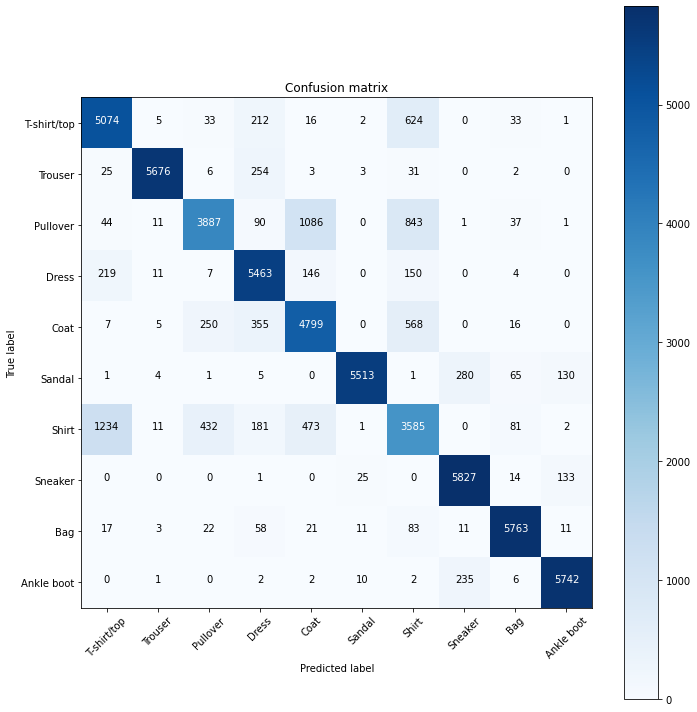

In [67]:
names = ('T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot')
plt.figure(figsize=(10,10))
plot_confusion_matrix(cmt,names)